<a href="https://colab.research.google.com/github/indrasary/Bert_Symptom_Extractor/blob/main/BERT_NER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. CONFIG

In [ ]:
!pip install --upgrade torch==2.1.0

In [ ]:
# import tensorflow as tf

In [ ]:
import torch

In [ ]:
USE_GDRIVE = False
if USE_GDRIVE:
  PROJECT_DIR = "drive/MyDrive/ColabNotebooks/"
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)
else:
  PROJECT_DIR = "./"
device = "cuda" if torch.cuda.is_available() else "cpu"

print(PROJECT_DIR)

./


### Load and Analyze Data

In [ ]:
!pip install --upgrade transformers
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv(PROJECT_DIR+'BERT_NER/data/overview-of-recordings.csv')
data1 = data[['phrase','prompt']]
data1.sample(5)

phrase            prompt
1470                    i have a pain in my elbow joint        Joint pain
5680              My hair is falling out in huge amount  Hair falling out
1016    There is pain in my joints. I can not bear pain        Joint pain
2928  I have a wound between my toes that gets bette...        Open wound
229   i can't ride my car at night because i have bl...     Blurry vision

In [ ]:
df=data1.copy()
df.isna().sum()

phrase    0
prompt    0
dtype: int64

In [ ]:
df['prompt'].value_counts()

prompt
Acne                  328
Shoulder pain         320
Joint pain            318
Infected wound        306
Knee pain             305
Cough                 293
Feeling dizzy         283
Muscle pain           282
Heart hurts           273
Ear ache              270
Hair falling out      264
Head ache             263
Feeling cold          263
Skin issue            262
Stomach ache          261
Back pain             259
Neck pain             251
Internal pain         248
Blurry vision         246
Body feels weak       241
Hard to breath        233
Emotional pain        231
Injury from sports    230
Foot ache             223
Open wound            208
Name: count, dtype: int64

In [ ]:
print('Total number of intents: %d'%(len(df['prompt'].value_counts().index)))

Total number of intents: 25


### 3. SPLIT DATA INTO TRAIN, VALIDATION, AND TEST SET

In [ ]:
from sklearn.model_selection import train_test_split

X, sentence_test, y, intent_test = train_test_split(df.phrase, df.prompt, stratify = df.prompt,test_size=0.2, random_state=4612)
sentence_train, sentence_val, intent_train, intent_val = train_test_split(X, y, stratify = y,test_size=0.125, random_state=4612)

In [ ]:
sentence_train = sentence_train[0:80]
sentence_val = sentence_val[0:20]
sentence_test = sentence_test[0:20]

intent_train = intent_train[0:80]
intent_val = intent_val[0:20]
intent_test = intent_test[0:20]

In [ ]:
print(f"#examples in training set:{ sentence_train.shape[0]}\n#examples in validation set:{ sentence_val.shape[0]}\n#examples in test set:{ sentence_test.shape[0]}")

#examples in training set:80
#examples in validation set:20
#examples in test set:20


### 4. TOKENIZATION AND INPUT FORMATTING

The input text format should meet the format as follows:


*   tokenizing all sentences
*   padding and truncating all sentences to the same length.
*   Creating the attention masks which explicitly differentiate real tokens from [PAD] tokens. 0 or 1.
*   encoding the label "intent" to numbers. 25 intents to 25 numbers.
*   creating DataLoaders for our training, validation and test sets







In [ ]:
# Defining some key variables that will be used later on in the training
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 4
EPSILON = 1e-08
EPOCHS = 4
LEARNING_RATE = 2e-5
SEED = 1215
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

/home/alkhemi/miniconda3/envs/torch2.1.0/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
max_len = 0
input = []
length=[]
# For every sentence...
for sent in sentence_train:

    # Tokenize the text and add special tokens--`[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    input.append(input_ids)
    length.append(len(input_ids))
    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))
    mean_len = sum(length)/len(length)
#39 tokens is the maximum number of tokens in a sentence (transcription). Also, a sentence has 14 tokens on average.
print('Max sentence length:%d \nMean sentence length:%d' % (max_len,mean_len))

Max sentence length:39 
Mean sentence length:13


In [ ]:
# create a function to tokenize sentences.
def tokenize(sentence):
  batch = tokenizer(list(sentence),
                  is_pretokenized=False,
                  #Pad or truncate all sentences to the same length. Create the attention masks which explicitly differentiate real tokens from [PAD] tokens.
                  padding=True,
                  truncation=True,
                  return_tensors="pt")
  return batch

In [ ]:
tok_train = tokenize(sentence_train)
tok_val = tokenize(sentence_val)
tok_test = tokenize(sentence_test)

Keyword arguments {'is_pretokenized': False} not recognized.
Keyword arguments {'is_pretokenized': False} not recognized.
Keyword arguments {'is_pretokenized': False} not recognized.
Keyword arguments {'is_pretokenized': False} not recognized.
Keyword arguments {'is_pretokenized': False} not recognized.
Keyword arguments {'is_pretokenized': False} not recognized.
Keyword arguments {'is_pretokenized': False} not recognized.
Keyword arguments {'is_pretokenized': False} not recognized.
Keyword arguments {'is_pretokenized': False} not recognized.
Keyword arguments {'is_pretokenized': False} not recognized.
Keyword arguments {'is_pretokenized': False} not recognized.
Keyword arguments {'is_pretokenized': False} not recognized.
Keyword arguments {'is_pretokenized': False} not recognized.
Keyword arguments {'is_pretokenized': False} not recognized.
Keyword arguments {'is_pretokenized': False} not recognized.
Keyword arguments {'is_pretokenized': False} not recognized.
Keyword arguments {'is_p

In [ ]:
from sklearn.preprocessing import LabelEncoder
# encode "intent" to 25 number labels
LE = LabelEncoder()
label_train = torch.tensor((LE.fit_transform(intent_train)))
label_val = torch.tensor((LE.fit_transform(intent_val)))
label_test = torch.tensor((LE.fit_transform(intent_test)))

In [ ]:
from torch.utils.data import TensorDataset

train_dataset = TensorDataset(tok_train['input_ids'], tok_train['attention_mask'],label_train)
validation_dataset = TensorDataset(tok_val['input_ids'], tok_val['attention_mask'],label_val)
test_dataset = TensorDataset(tok_test['input_ids'], tok_test['attention_mask'],label_test)

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = TRAIN_BATCH_SIZE # Trains with this batch size.
        )

# For validation/test the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            validation_dataset, # The validation samples.
            sampler = SequentialSampler(validation_dataset), # Pull out batches sequentially.
            batch_size = VALID_BATCH_SIZE # Evaluate with this batch size.
        )

test_dataloader = DataLoader(
            validation_dataset,
            sampler = SequentialSampler(validation_dataset),
            batch_size = VALID_BATCH_SIZE
        )

### 5. Train BERT classification model

In [69]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

## use pretained base(relatively small) BERT mdoel for sequence classification
#CUDA_LAUNCH_BLOCKING=1
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = 25, output_attentions=True)
#model.cuda() # make pytorch run this model on GPU.

## use AdamW optimizer
optimizer = AdamW(model.parameters(),
                  lr = LEARNING_RATE,
                  eps = EPSILON) #very small number to prevent any division by zero

from transformers import get_linear_schedule_with_warmup

# Total number of training steps is [number of batches] x [number of epochs].
total_steps = len(train_dataloader) * EPOCHS

## Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Function to calcuate the accuracy of the model

def calcuate_accu(big_idx, targets):
    n_correct = (big_idx==targets).sum().item()
    return n_correct

In [ ]:
import time
import datetime

def format_time(elapsed):
    #Takes a time in seconds and returns a string hh:mm:ss
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
!pip install tensorboard

  Using cached tensorboard-2.15.1-py3-none-any.whl.metadata (1.7 kB)
  Using cached absl_py-2.0.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached google_auth-2.23.4-py2.py3-none-any.whl.metadata (4.7 kB)
  Using cached google_auth_oauthlib-1.1.0-py2.py3-none-any.whl.metadata (2.7 kB)
  Using cached Markdown-3.5.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached protobuf-4.23.4-cp37-abi3-manylinux2014_x86_64.whl.metadata (540 bytes)
  Using cached tensorboard_data_server-0.7.2-py3-none-manylinux_2_31_x86_64.whl.metadata (1.1 kB)
  Using cached werkzeug-3.0.1-py3-none-any.whl.metadata (4.1 kB)
  Using cached cachetools-5.3.2-py3-none-any.whl.metadata (5.2 kB)
  Using cached pyasn1_modules-0.3.0-py2.py3-none-any.whl (181 kB)
  Using cached rsa-4.9-py3-none-any.whl (34 kB)
  Using cached requests_oauthlib-1.3.1-py2.py3-none-any.whl (23 kB)
  Using cached oauthlib-3.2.2-py3-none-any.whl (151 kB)
Using cached tensorboard-2.15.1-py3-none-any.whl (5.5 MB)
Using cached absl_py-2.0.0-py3-none

In [ ]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/Tensorboard')


In [ ]:
# Start the training process:
import random
import torch

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

#torch.cuda.manual_seed_all(SEED)
def train(epochs):
  total_t0 = time.time() # Measure the total training time for the whole run.
  tr_loss = 0
  n_correct = 0
  nb_tr_steps = 0
  nb_tr_examples = 0

  # For each epoch...
  for epoch in range(0, epochs):
      print('======== Epoch {:} / {:} ========'.format(epoch + 1, epochs))
      print('Training...')

      t0 = time.time()     # Measure how long the training epoch takes.
      total_tr_loss = 0
      total_n_correct = 0
      total_nb_tr_examples = 0
      model.train()    # Put the model into training mode

      # For each batch of training data...
      for step, batch in enumerate(train_dataloader, 0):
          # 'batch' contains three pytorch tensors:[0]: input ids, [1]: attention masks, [2]: labels
          input_ids = batch[0].to(device, dtype = torch.long)
          input_mask = batch[1].to(device, dtype = torch.long)
          labels = batch[2].to(device, dtype = torch.long)

          model.zero_grad()       #clear any previously calculated gradients

          outputs = model(input_ids, token_type_ids=None, attention_mask=input_mask)
          loss_function = torch.nn.CrossEntropyLoss()
          loss = loss_function(outputs[0], labels) #`loss` is a Tensor containing a single value
          tr_loss += loss.item() #.item()` function just returns the Python value from the tensor
          total_tr_loss += loss.item()
          big_val, big_idx = torch.max(outputs[0], dim=1)
          n_correct += calcuate_accu(big_idx, labels)
          total_n_correct += calcuate_accu(big_idx, labels)
          nb_tr_steps += 1
          nb_tr_examples+=labels.size(0)
          total_nb_tr_examples+=labels.size(0)

          if step % 20==19:
              loss_step = tr_loss/nb_tr_steps
              accu_step = n_correct/nb_tr_examples # #correct examples/all examples
              print(f"Training Loss per 20 steps(batches): {loss_step}")
              print(f"Training Accuracy per 20 steps(batches): {accu_step}")
              elapsed = format_time(time.time() - t0)    # Calculate elapsed time in minutes.
              # Report progress.
              print('Batch {} of {}.  Elapsed: {:}.'.format(step+1, len(train_dataloader), elapsed))
              #writer.add_scalar('training loss', loss_step, (epoch +1)*len(trainloader) )
              tr_loss = 0;n_correct = 0;nb_tr_steps = 0;nb_tr_examples = 0

          loss.backward() # Perform a backward pass to calculate the gradients.
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # Clip the norm of the gradients to 1.0. This is to help prevent the "exploding gradients" problem.
          optimizer.step()
          scheduler.step() # Update the learning rate.

      # Measure how long this epoch took.
      training_time = format_time(time.time() - t0)

      # validation phase
      val_loss = 0
      val_n_correct = 0
      nb_val_steps = 0
      nb_val_examples = 0

      t0 = time.time()     # Measure how long the valid epoch takes.
      total_val_loss = 0
      total_n_val_correct = 0
      total_nb_val_examples = 0
      # For each batch of validation data...
      for step, batch in enumerate(validation_dataloader, 0):
          # 'batch' contains three pytorch tensors:[0]: input ids, [1]: attention masks, [2]: labels
          input_ids = batch[0].to(device, dtype = torch.long)
          input_mask = batch[1].to(device, dtype = torch.long)
          labels = batch[2].to(device, dtype = torch.long)

          outputs = model(input_ids, token_type_ids=None, attention_mask=input_mask)
          loss_function = torch.nn.CrossEntropyLoss()
          loss = loss_function(outputs[0], labels) #`loss` is a Tensor containing a single value
          val_loss += loss.item() #.item()` function just returns the Python value from the tensor
          total_val_loss += loss.item()
          big_val, big_idx = torch.max(outputs[0], dim=1)
          val_n_correct += calcuate_accu(big_idx, labels)
          total_n_val_correct += calcuate_accu(big_idx, labels)
          nb_val_steps += 1
          nb_val_examples+=labels.size(0)
          total_nb_val_examples+=labels.size(0)

          if step % 20==19:
              loss_step = val_loss/nb_val_steps
              accu_step = n_correct/nb_val_examples # #correct examples/all examples
              print(f"Validation Loss per 20 steps(batches): {loss_step}")
              print(f"Validation Accuracy per 20 steps(batches): {accu_step}")
              elapsed = format_time(time.time() - t0)    # Calculate elapsed time in minutes.
              # Report progress.
              print('Batch {} of {}.  Elapsed: {:}.'.format(step+1, len(validation_dataloader), elapsed))
              val_loss = 0; n_correct = 0; nb_val_steps = 0; nb_val_examples = 0


    # Calculate the average loss over all of the batches.
      train_loss_per_epoch = total_tr_loss / len(train_dataloader)
      train_accuracy_per_epoch=total_n_correct/total_nb_tr_examples
      train_losses.append(train_loss_per_epoch)
      train_accuracies.append(train_accuracy_per_epoch)

      valid_loss_per_epoch = total_val_loss / len(validation_dataloader)
      valid_accuracy_per_epoch=total_n_val_correct/total_nb_val_examples
      valid_losses.append(valid_loss_per_epoch)
      valid_accuracies.append(valid_accuracy_per_epoch)

      # Measure how long this epoch took.
      validation_time = format_time(time.time() - t0)

      print("")
      print("training loss per epoch: {0:.2f}".format(train_loss_per_epoch))
      print("training accuracy per epoch: {0:.2f}".format(train_accuracy_per_epoch))
      print("Training 1 epoch took: {:}".format(training_time))
      print("")
      print("validation loss per epoch: {0:.2f}".format(valid_loss_per_epoch))
      print("validation accuracy per epoch: {0:.2f}".format(valid_accuracy_per_epoch))
      print("validation 1 epoch took: {:}".format(validation_time))

In [ ]:
train(epochs = EPOCHS)

======== Epoch 1 / 4 ========
Training...
Training Loss per 20 steps(batches): 3.045952653884888
Training Accuracy per 20 steps(batches): 0.1125
Batch 20 of 20.  Elapsed: 0:00:16.

training loss per epoch: 3.05
training accuracy per epoch: 0.11
Training 1 epcoh took: 0:00:17

validation loss per epoch: 3.34
validation accuracy per epoch: 0.00
validation 1 epcoh took: 0:00:00
======== Epoch 2 / 4 ========
Training...
Training Loss per 20 steps(batches): 3.00895574092865
Training Accuracy per 20 steps(batches): 0.175
Batch 20 of 20.  Elapsed: 0:00:17.

training loss per epoch: 3.01
training accuracy per epoch: 0.17
Training 1 epcoh took: 0:00:18

validation loss per epoch: 3.40
validation accuracy per epoch: 0.05
validation 1 epcoh took: 0:00:01
======== Epoch 3 / 4 ========
Training...
Training Loss per 20 steps(batches): 2.9503625869750976
Training Accuracy per 20 steps(batches): 0.175
Batch 20 of 20.  Elapsed: 0:00:17.

training loss per epoch: 2.95
training accuracy per epoch: 0.17
T

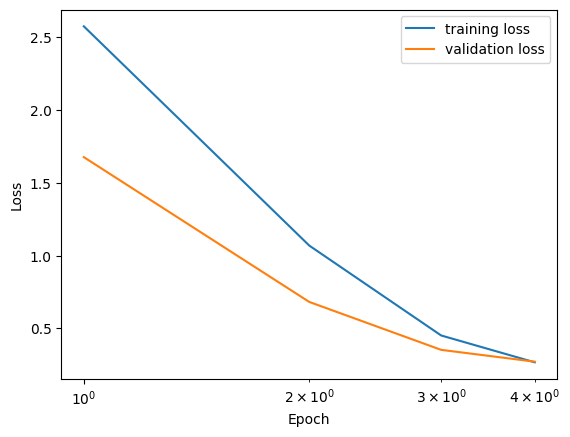

In [64]:
from matplotlib import pyplot as plt

plt.semilogx([1,2,3,4], train_losses, label = 'training loss')
plt.semilogx([1,2,3,4], valid_losses, label = 'validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

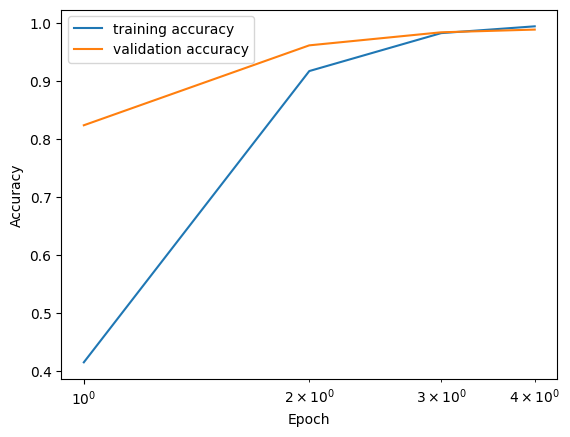

In [65]:
from matplotlib import pyplot as plt

plt.semilogx([1,2,3,4], train_accuracies, label = 'training accuracy')
plt.semilogx([1,2,3,4], valid_accuracies, label = 'validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### 6. Test the model on the validation set

In [ ]:
# test the model on the validation set
def valid(model, validation_loader):
  model.eval()
  val_loss = 0
  nb_val_examples = 0
  n_correct = 0
  with torch.no_grad():
    for _, data in enumerate(validation_loader, 0):
      ids = data[0].to(device, dtype = torch.long)
      mask = data[1].to(device, dtype = torch.long)
      targets = data[2].to(device, dtype = torch.long)
      outputs = model(ids, mask)
      loss_function = torch.nn.CrossEntropyLoss()
      loss = loss_function(outputs[0], targets)
      val_loss += loss.item()
      big_val, big_idx = torch.max(outputs[0], dim=1)
      n_correct += calcuate_accu(big_idx, targets)
      nb_val_examples+=targets.size(0)

  val_ave_loss = val_loss/len(validation_loader)
  val_accu = (n_correct*100)/nb_val_examples
  print("Loss on validation/test data: %0.2f" % val_ave_loss)
  print("Accuracy on validation/test data: %0.2f%%" % val_accu)

  return

### 7. Obtain Test Error

In [ ]:
valid(model, validation_dataloader)

Loss on validation/test data: 0.13
Accuracy on validation/test data: 99.40%


### 8. Save the model, tokenizer, and label

In [ ]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = PROJECT_DIR+'BERT_NER/saved_bert_model_and_tokenizer'

# Create output directory if needed
if not os.path.exists(output_dir):
  os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
# model_to_save.save_pretrained(output_dir+"/model.h5")
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Saving model to ./BERT_NER/saved_bert_model_and_tokenizer


('./BERT_NER/saved_bert_model_and_tokenizer/tokenizer_config.json',
 './BERT_NER/saved_bert_model_and_tokenizer/special_tokens_map.json',
 './BERT_NER/saved_bert_model_and_tokenizer/vocab.txt',
 './BERT_NER/saved_bert_model_and_tokenizer/added_tokens.json')

In [ ]:
df_label = pd.DataFrame(tuple(zip(range(25),LE.classes_)), columns=['id','intent'])
df_label.to_pickle( PROJECT_DIR+'BERT_NER/saved_bert_model_and_tokenizer/df_label.pkl')

In [ ]:
# Copy the model files to a directory in Google Drive.
!cp -r  PROJECT_DIR+'BERT_NER/saved_bert_model_and_tokenizer/df_label.pkl'

cp: missing destination file operand after 'PROJECT_DIR+BERT_NER/saved_bert_model_and_tokenizer/df_label.pkl'
Try 'cp --help' for more information.


### 9. Prepare the model for deployment

*   Load the saved model, tokenizer and labels
*   Create a medical_symptom_detector function with the loaded model, tokenizer and labels, which helps predict the medical intent of a medical message.
*   Test the detector on an unseen example







In [ ]:
#### load the model and build the detector for deployment
#!pip install transformers
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification

input_dir = PROJECT_DIR+'BERT_NER/saved_bert_model_and_tokenizer/'

loaded_model = BertForSequenceClassification.from_pretrained(input_dir, ignore_mismatched_sizes=True)
loaded_model.eval()
loaded_tokenizer = BertTokenizer.from_pretrained(input_dir)
loaded_df_label = pd.read_pickle(PROJECT_DIR+'BERT_NER/saved_bert_model_and_tokenizer/df_label.pkl')

In [ ]:
loaded_model.eval()
loaded_tokenizer = BertTokenizer.from_pretrained(input_dir)
loaded_df_label = pd.read_pickle(PROJECT_DIR+'BERT_NER/saved_bert_model_and_tokenizer/df_label.pkl')

In [70]:
# test the model on an unseen example

def medical_symptom_detector(intent):

  pt_batch = loaded_tokenizer(
  intent,
  padding=True,
  truncation=True,
  return_tensors="pt")

  pt_outputs = loaded_model(**pt_batch)
  __, id = torch.max(pt_outputs[0], dim=1)
  prediction = loaded_df_label.iloc[[id.item()]]['intent'].item()
  print('You may have a medical condition: %s. Would you like me to transfer your call to your doctor?'%(prediction))
  return prediction

In [73]:
input = "I'm just having a lot of chest pain and and so I thought I should get it checked out"
prediction = medical_symptom_detector(input)

You may have a medical condition: Heart hurts. Would you like me to transfer your call to your doctor?


### 10. Plot BERT For Sequence Classifier Model

In [66]:
import sys
!test -d bertviz_repo && echo

In [67]:
from bertviz import head_view
from transformers import BertTokenizer, BertModel

In [68]:
def call_html():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              "d3": "https://cdnjs.cloudflare.com/ajax/libs/d3/3.5.8/d3.min",
              jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
            },
          });
        </script>
        '''))

In [74]:
inputs = tokenizer.encode_plus(input, prediction, return_tensors='pt', add_special_tokens=True)
token_type_ids = inputs['token_type_ids']
input_ids = inputs['input_ids']
attention = model(input_ids, token_type_ids=token_type_ids)[-1]
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list)
call_html()

head_view(attention, tokens)

<IPython.core.display.Javascript object>